In [349]:
import os
import os.path as op

import importlib
import numpy as np
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

import nibabel as nib
from nilearn import datasets, image

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch
%matplotlib inline

from seaborn import kdeplot

import networkx as nx

import dgsp
import graph_examples as dgsp_graphs
import bimod_plots as plot

In [350]:
n_samples = 10

orig_cmap = plt.get_cmap("rainbow", n_samples)
colorlist = ["k"] + [orig_cmap(i) for i in range(n_samples)]
custom_cmap = LinearSegmentedColormap.from_list("", colorlist)

exclude = [4]
cluster_colors8 = [custom_cmap.resampled(8+1)(i+1) for i in range(8) if i not in exclude]

cmap_8clusters = LinearSegmentedColormap.from_list("", ["k"] + cluster_colors8)

## Toy Signals

In [351]:
n_per_com = 40
n_blocks = 4
com_density = 0.5
connect_density = 0.5

seed = 220367

adj = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density, seed=seed)

circular_pos, graph_pos = plot.circular_layout(n_blocks, n_per_com, radius=2, small_radius=1.2, return_dict=True)

n_cycles = 2
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_blocks

    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

## Concatenate

In [118]:
n_vec_max = 2
n_kmeans = 8

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx, _, cluster_mat  = dgsp.get_c_pinv(adj, n_vec_max, n_kmeans, normalize=False, verbose=False, return_clusters=True)

C_mat = np.concatenate([C_mat_out, C_mat_in])

n_cycles = 1
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_blocks

    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

C_pinv = np.linalg.pinv(C_mat)
print(C_pinv.shape)

(8, 320)


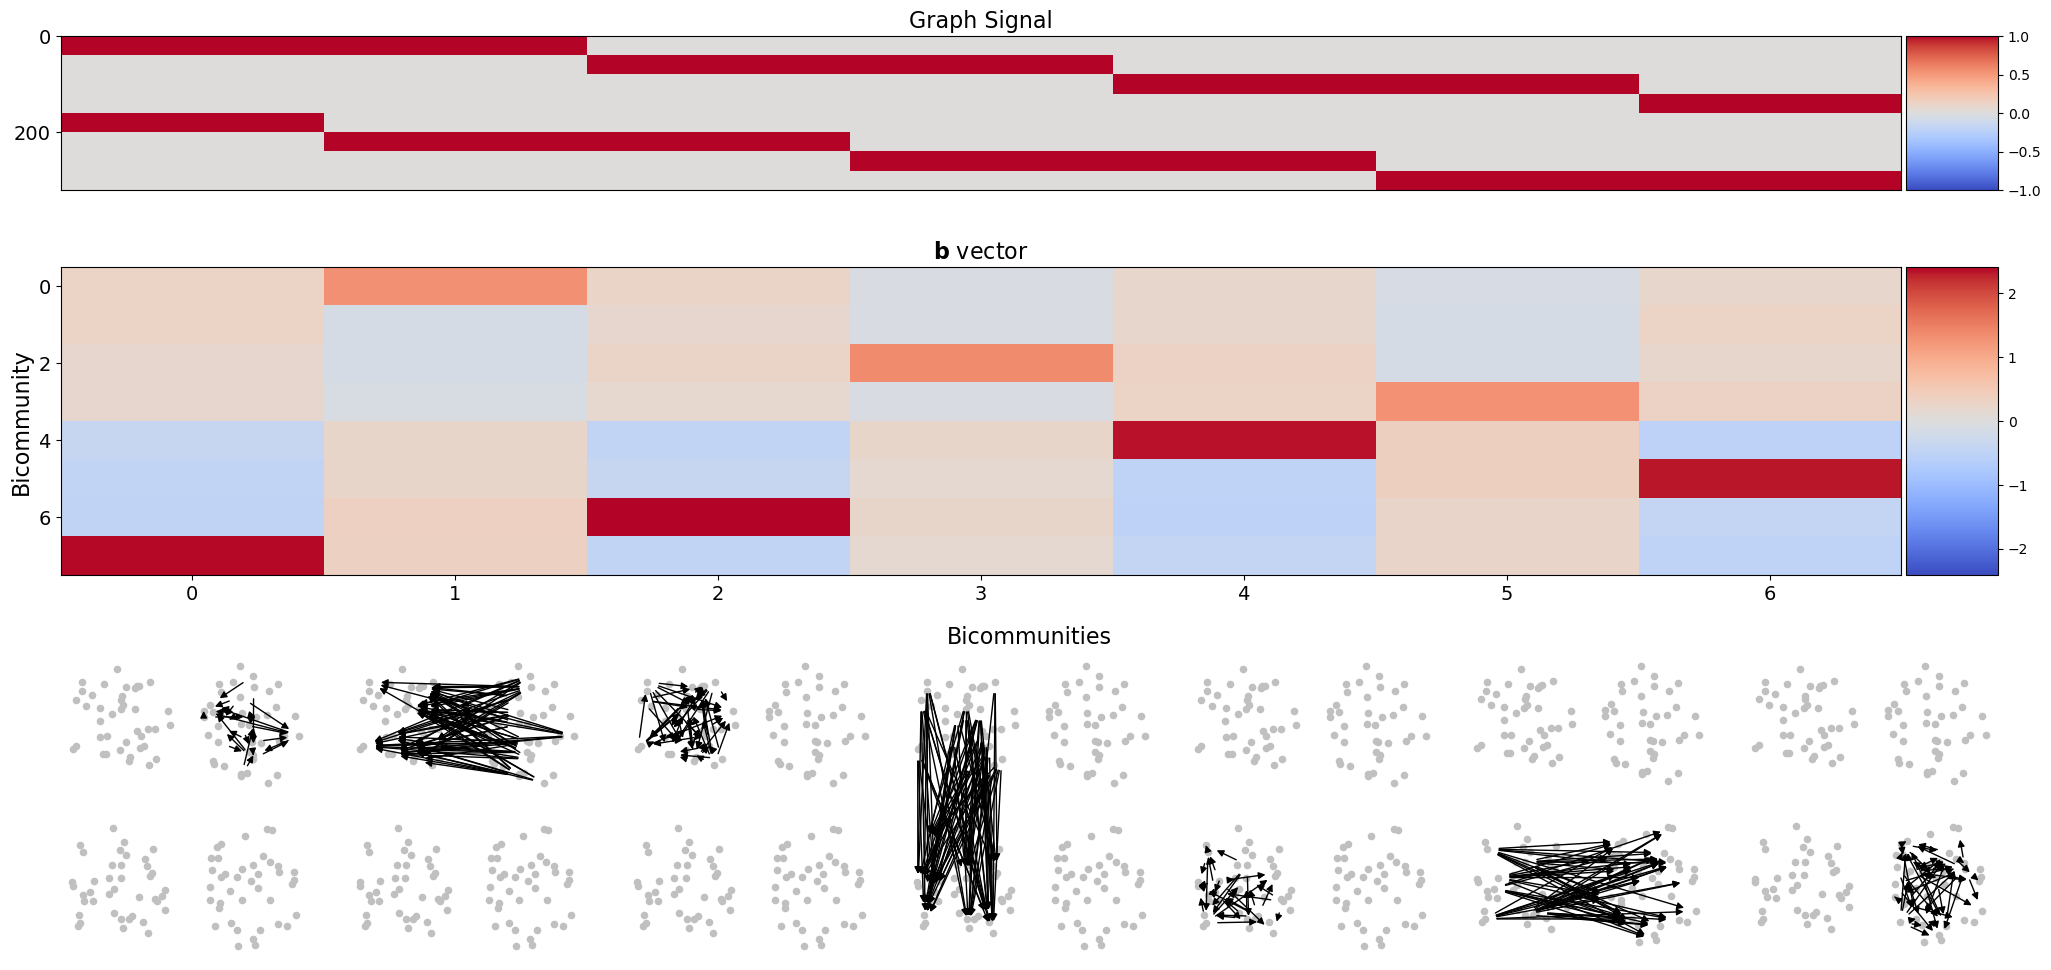

In [121]:
x_concat = np.zeros((2*n_timepoints-1, 2*len(adj)))

x_concat[::2] = np.concatenate([block_signal, block_signal]).T
x_concat[1::2] = np.concatenate([block_signal[:, :-1], block_signal[:, 1:]]).T

proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

# axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
# for k in range(3):
#     axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
# ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, 2*n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(2*n_timepoints-1)]

max_com = np.argmax(proj_signals, axis=1)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    red_mat[red_mat != max_com[i] + 1] = 0
    # for k in range(n_kmeans):
    #     red_mat[red_mat == k+1] *= proj_signals.T[k, i]

    # red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

## Undirected Case

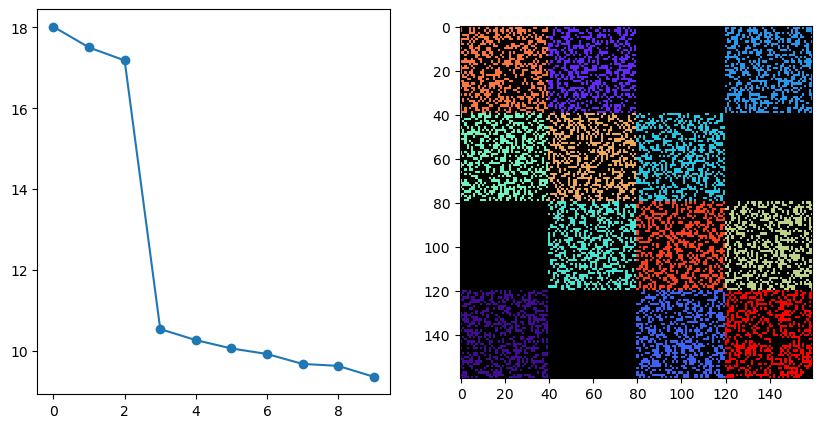

In [453]:
importlib.reload(dgsp)

n_per_com = 40
n_blocks = 4
com_density = 0.4
connect_density = 0.4

adj_sym = dgsp_graphs.block_cycle(n_per_com, n_blocks=n_blocks, com_density=com_density, connect_density=connect_density).astype(float)

adj_sym = ((adj_sym + adj_sym.T) > 0).astype(int)

n_vec_max = 3
n_kmeans = 12

U_sym, S_sym, Vh = dgsp.sorted_SVD(dgsp.modularity_matrix(adj_sym))
V_sym = Vh.T

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].plot(S_sym[:10], marker="o")

C_mat_out, c_pinv_out, C_mat_in, c_pinv_in, bimod_idx, edge_clusters, cluster_mat = dgsp.get_c_pinv(adj_sym, n_vec_max, n_kmeans,
                                                                                                    normalize=False, verbose=False,
                                                                                                    return_clusters=True)

axes[1].imshow(cluster_mat, cmap=cmap_8clusters, interpolation="none")

(12, 8)


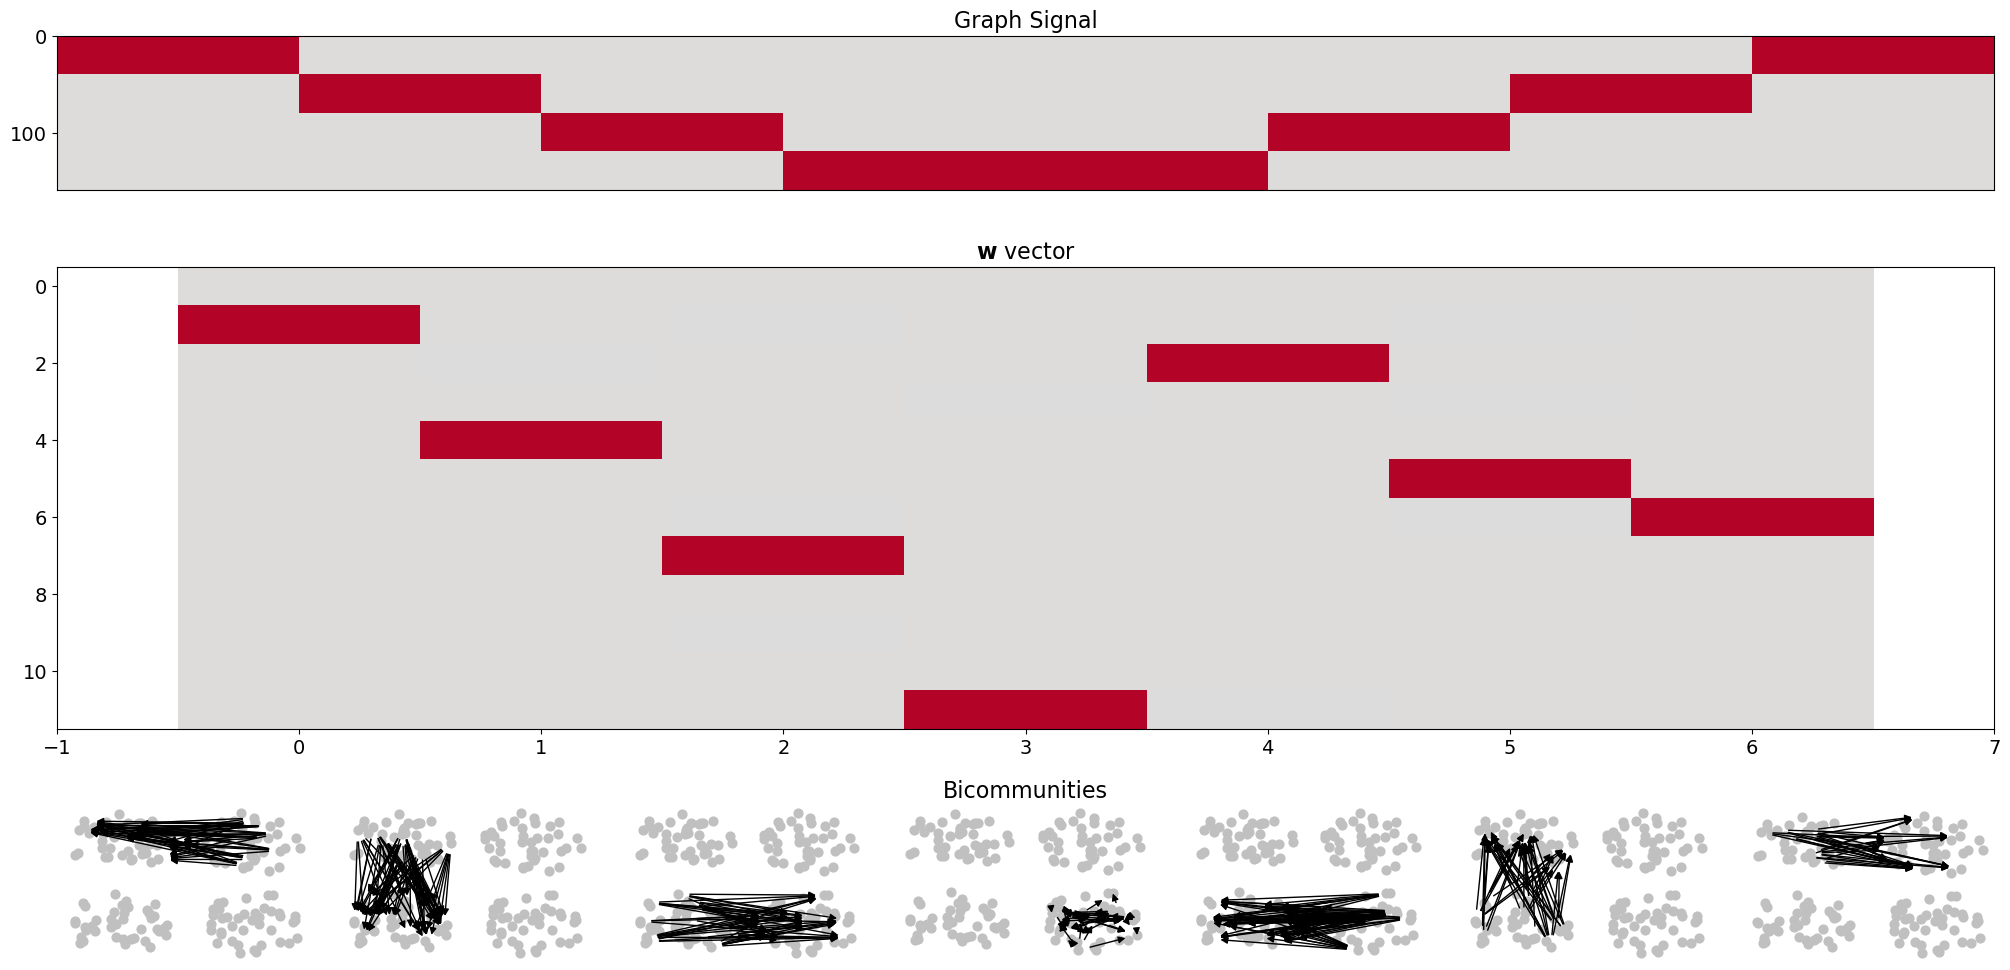

In [457]:
n_cycles = 2
n_timepoints = n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % n_blocks

    block_signal[n_per_com*(block):n_per_com*(block+1), t] = 1

block_signal[:, n_timepoints//2:] = np.flip(block_signal[:, :n_timepoints//2], axis=1)
W_out = (c_pinv_out @ block_signal)
print(W_out.shape)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat, rcond=1e-10)

    if np.linalg.norm(D_pinv) > 1e5:
        print(f"Warning: Large norm of D_pinv at timepoint {i} !")

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 3, 1]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)

maxval = np.log(b_vectors.max())
minval = -maxval

axes[1].set_title("$\mathbf{w}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
ax.set_xlim(-1, n_timepoints-1)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints-1)]

max_com = np.argmax(b_vectors, axis=0)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    #red_mat[red_mat != max_com[i] + 1] = 0
    for k in range(n_kmeans):
        red_mat[red_mat == k+1] *= b_vectors[k, i]

    red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=40, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)

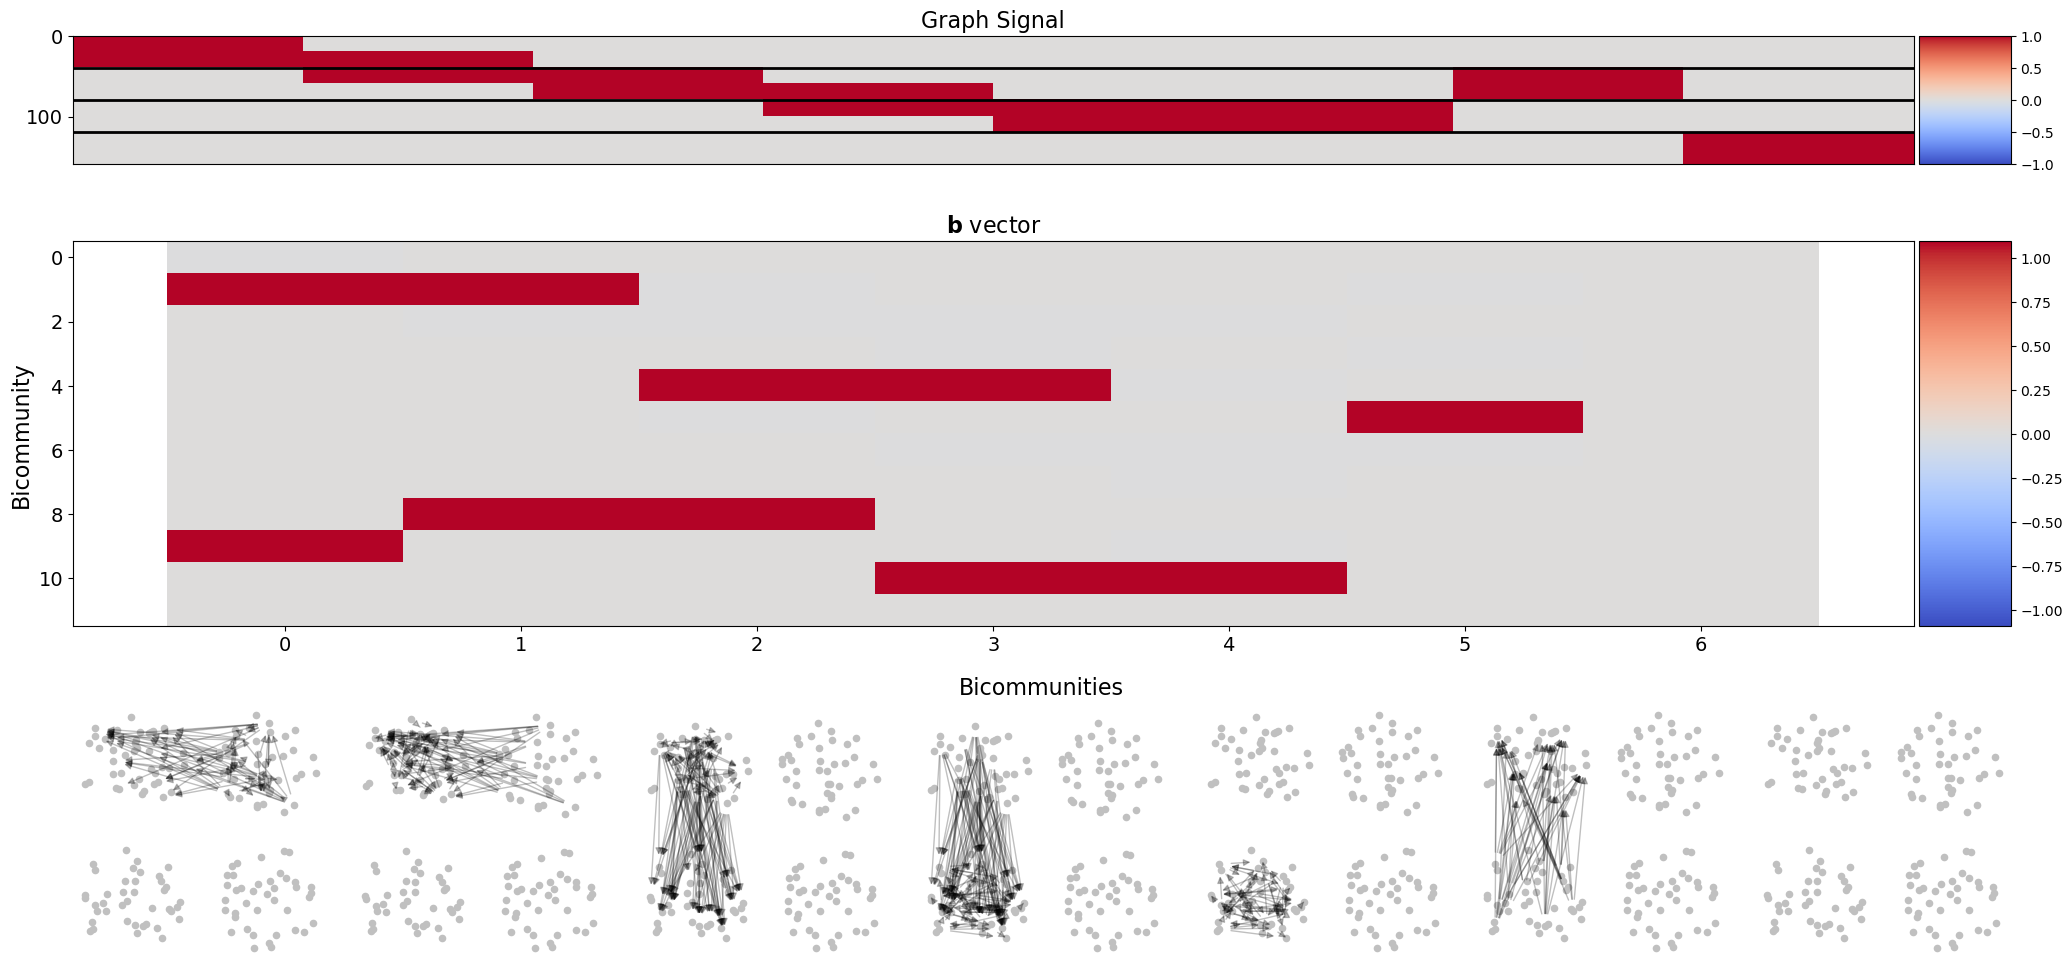

In [458]:
n_cycles = 2
overlap = 2

n_timepoints = overlap*n_cycles*n_blocks

block_signal = np.zeros((n_per_com*n_blocks, n_timepoints))
for t in range(n_timepoints):
    block = t % (overlap*n_cycles)

    block_signal[n_per_com//overlap*(block):n_per_com//overlap*(block+overlap), t] = 1

block_signal = np.insert(block_signal, 4, np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
block_signal = np.insert(block_signal, 4, np.roll(block_signal[:, 0], 2*n_per_com), axis=1)
block_signal = np.insert(block_signal, 6, np.roll(block_signal[:, 0], 1*n_per_com), axis=1)
block_signal = np.insert(block_signal, 7, np.roll(block_signal[:, 0], 3*n_per_com), axis=1)

block_signal = block_signal[:, :8]

n_timepoints = len(block_signal[0])

W_out = (c_pinv_out @ block_signal)

b_vectors = np.zeros((n_kmeans, n_timepoints - 1))
for i, w_out in enumerate(W_out.T[:-1]):
    D_mat = C_mat_in @ np.diag(w_out)
    D_pinv = np.linalg.pinv(D_mat, rcond=1e-10)

    if np.linalg.norm(D_pinv) > 1e5:
        print(f"Warning: Large norm of D_pinv at timepoint {i} !")

    b_vectors[:, i] = D_pinv @ block_signal[:, i+1]

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 3, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

for k in range(3):
    axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = np.log(b_vectors.max())
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(b_vectors, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(n_timepoints-1)]

max_com = np.argmax(b_vectors, axis=0)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    #red_mat[red_mat != max_com[i] + 1] = 0
    for k in range(n_kmeans):
        red_mat[red_mat == k+1] *= b_vectors[k, i]

    red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax, alpha=0.25)

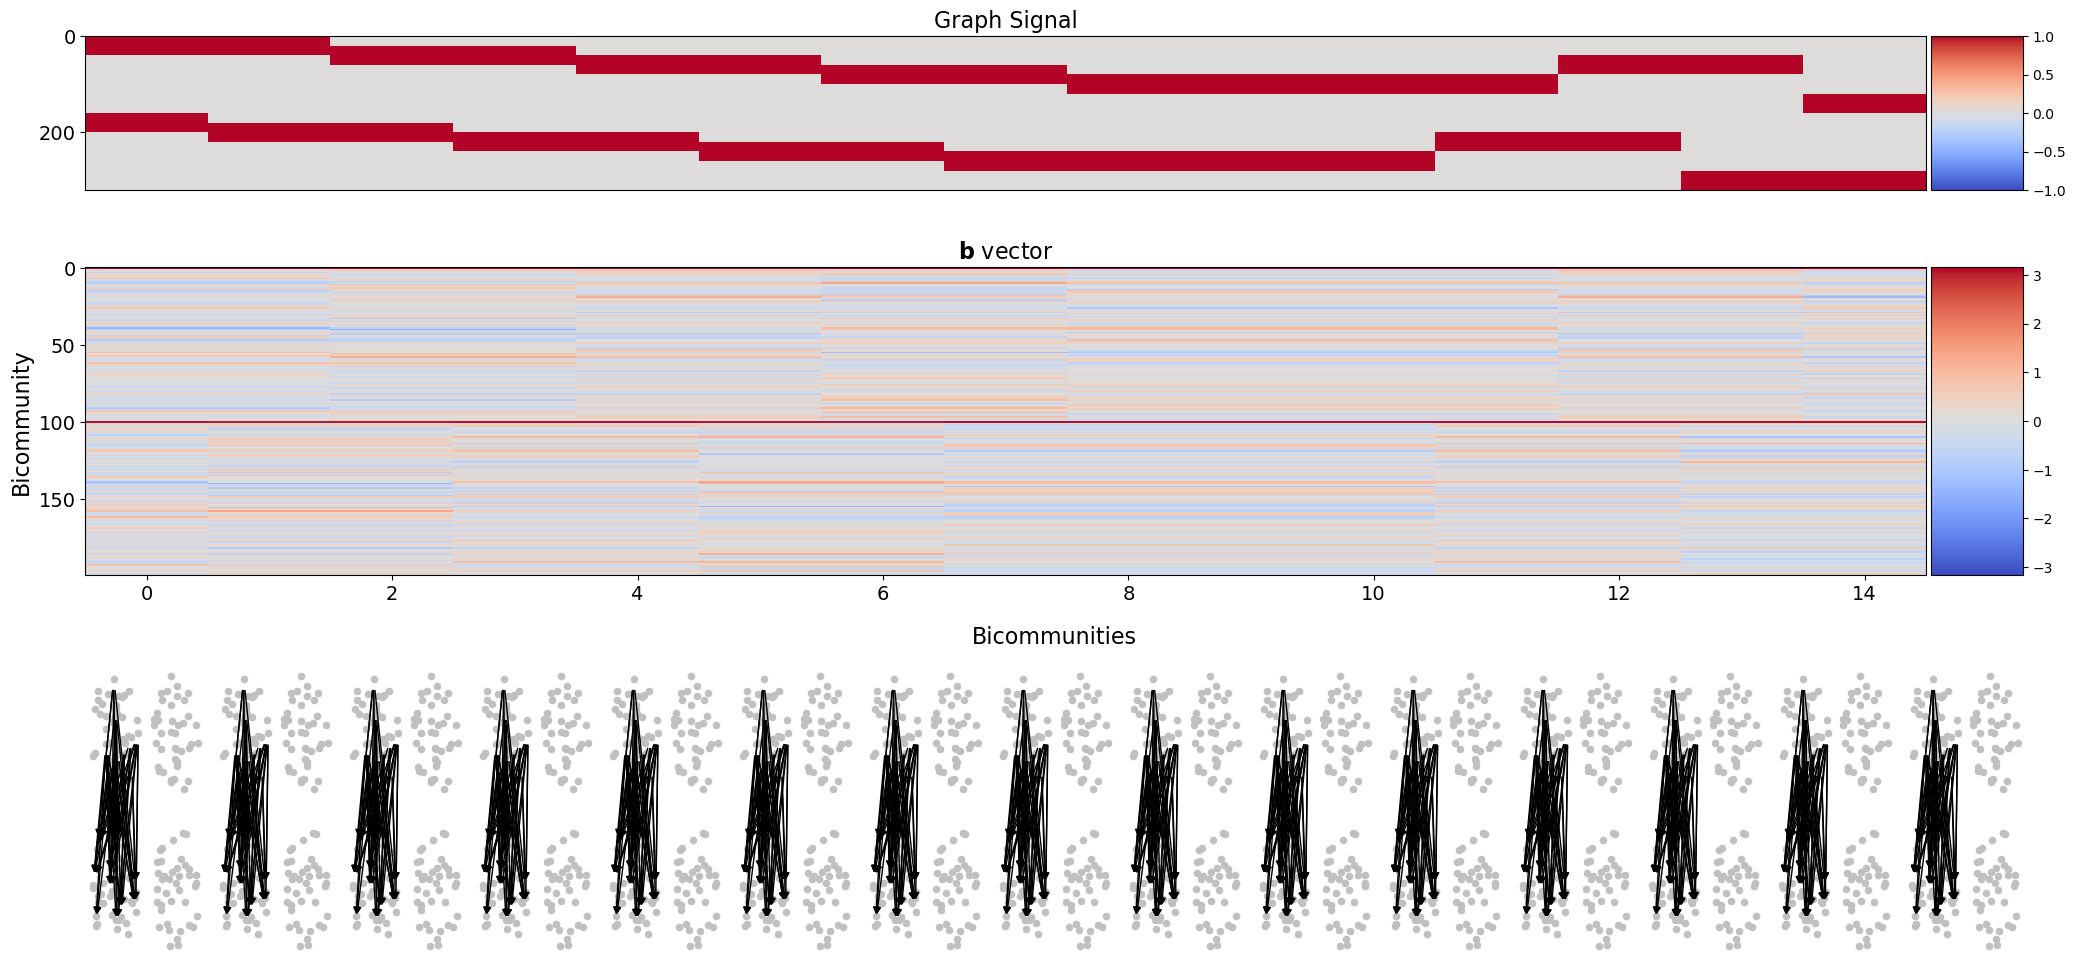

In [452]:
x_concat = np.zeros((2*n_timepoints-1, 2*len(adj)))

x_concat[::2] = np.concatenate([block_signal, block_signal]).T
x_concat[1::2] = np.concatenate([block_signal[:, :-1], block_signal[:, 1:]]).T

proj_signals = np.array([C_pinv @ x_t for x_t in x_concat])

fig, axes = plt.subplots(nrows=3, figsize=(25, 12), gridspec_kw={"hspace":0.3, "height_ratios":[1, 2, 2]})

axes[0].set_title("Graph Signal", fontsize=16)
axes[0].imshow(x_concat.T, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)

# axes[0].imshow(block_signal, aspect="auto", cmap="coolwarm", interpolation="none", vmin=-1, vmax=1)
# for k in range(3):
#     axes[0].hlines((k+1)*n_per_com-1, -0.5, n_timepoints-0.5, color="k", linewidth=2)

axes[0].set_xticks([])
axes[0].tick_params(labelsize=14)
plot.add_cbar(fig, axes[0])

maxval = proj_signals.max()
minval = -maxval

axes[1].set_title("$\mathbf{b}$ vector", fontsize=16)
ax = axes[1]
ax.imshow(proj_signals.T, cmap="coolwarm", vmin=minval, vmax=maxval, aspect="auto", interpolation="none")

ax.tick_params(labelsize=14)
# ax.set_xlabel("Time", fontsize=16)
# ax.set_xlim(-0.9, n_timepoints-1.1)
ax.set_ylabel("Bicommunity", fontsize=16)
plot.add_cbar(fig, ax)

axes[2].set_title("Bicommunities", fontsize=16)
axes[2].axis("off")
gs = GridSpecFromSubplotSpec(1, 2*n_timepoints-1, subplot_spec=axes[2], wspace=0.1)
axes_bicom = [fig.add_subplot(gs[i]) for i in range(2*n_timepoints-1)]

max_com = np.argmax(proj_signals, axis=1)

edge_prop = 0.3
net_red = [np.random.choice(n_per_com*n_blocks, int((1-edge_prop)*n_per_com*n_blocks), replace=False) for i in range(2)]

for i, ax in enumerate(axes_bicom):
    ax.axis("off")
    
    red_mat = cluster_mat.copy().astype(float)
    red_mat[red_mat != max_com[i] + 1] = 0
    # for k in range(n_kmeans):
    #     red_mat[red_mat == k+1] *= proj_signals.T[k, i]

    # red_mat[np.abs(red_mat) < 0.1] = 0

    red_mat[net_red[0], :] = 0
    red_mat[:, net_red[1]] = 0

    ax.scatter(circular_pos[0], circular_pos[1], s=20, color="silver")#, edgecolors="k", linewidths=1, zorder=2)
    nx.draw_networkx_edges(nx.DiGraph(red_mat), pos=graph_pos, ax=ax)